<img src = 'https://media.nationalgeographic.org/assets/photos/000/273/27302_c0-41-990-701_r1050x700.jpg?d4ccf3044d9da0d0118103be3a76bd1319370847' >

## Brief Introduction about Titanic Ship
Titanic was a British passenger liner operated by the White Star Line that sank in the North Atlantic Ocean in the early morning hours of 15 April 1912, after striking an iceberg during her maiden voyage from Southampton to New York City. Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, making the sinking one of modern history's deadliest peacetime commercial marine disasters.
Though there were about 2,224 passengers and crew members, we are given data of about 1,300 passengers. Out of these 1,300 passengers details, about 9000 data is used for training purpose and remaining 400 is used for test purpose. In this competition we are given about 400 test data with missing survived column and we have to use different machine learning algorithms to predict whether the passengers in the test data survived or not.
Both training and test data arenot clean(contains lots of missing values), so main goal of this competition is to clean the data and build the model with best accuracy.

## Understanding the data



Survival : 0 = No, 1 = Yes

Pclass : A proxy for socio-economic status (SES) 1st = Upper 2nd = Middle 3rd = Lower

sibsp : The # of siblings / spouses aboard the Titanic Sibling = brother, sister, stepbrother, stepsister Spouse = 

husband, wife (mistresses and fiancés were ignored)

parch : The # of parents / children aboard the Titanic Parent = mother, father Child = daughter, son, 
stepdaughter, stepson Some children travelled only with a nanny, therefore parch=0 for them.

Ticket : Ticket number

Fare : Passenger fare

Cabin : Cabin number embarked

Port of Embarkation: C = Cherbourg, Q = Queenstown, S = Southampton

Name, Sex , Age are self-explanatory



## Importing all necessary libraries


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import enum
% matplotlib inline

UsageError: Line magic function `%` not found.


In [6]:
class Mode(enum.Enum):
    TRAIN = "TRAIN"
    TEST = "TEST"

## Define the current run-mode

In [41]:
MODE=Mode.TRAIN

### Load the data

In [8]:
train_data = pd.read_csv('../../input/titanic/train.csv')
test_data = pd.read_csv('../../input/titanic/test.csv')

# Dealing with the Missing values

In [9]:
# before filling the missing values, let's drop Cabin column from both data.
train_data.drop('Cabin', axis=1, inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

In [10]:
combined_data = [train_data, test_data]
for data in combined_data:
    print(data.isnull().sum())
    print('*' * 20)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64
********************
PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Embarked        0
dtype: int64
********************


In [11]:
# filling the nan values fo Age and fare column with the mean while Embarked column with most_frequent value
for data in combined_data:
    data.Age.fillna(data.Age.mean(), inplace=True)
    data.Fare.fillna(data.Fare.mean(), inplace=True)

# from visualization we know that Southamptom is most frequent Embarked place so, filling the missing value 
# with 'S'
train_data.Embarked.fillna('S', inplace=True)

## Converting a categorical feature¶



##### Let's  start by converting Sex feature to categorical  female=1 and male=0

In [12]:
def change_gender(x):
    if x == 'male':
        return 0
    elif x == 'female':
        return 1


train_data.Sex = train_data.Sex.apply(change_gender)
test_data.Sex = test_data.Sex.apply(change_gender)

**using map funcion to change the Embarked column S = 1, C = 2, Q = 0**

In [13]:
change = {'S': 1, 'C': 2, 'Q': 0}
train_data.Embarked = train_data.Embarked.map(change)
test_data.Embarked = test_data.Embarked.map(change)

# Feature Extraction


while visualizing the correlation heatmap we came to know that Sibsp and Parch columns were closely related 
so lets created new column called Alone using this two columns
-------> 1 = Alone , 0 = not Alone

In [14]:
train_data['Alone'] = train_data.SibSp + train_data.Parch
test_data['Alone'] = test_data.SibSp + test_data.Parch

train_data.Alone = train_data.Alone.apply(lambda x: 1 if x == 0 else 0)
test_data.Alone = test_data.Alone.apply(lambda x: 1 if x == 0 else 0)

In [15]:
# now lets drop SibSp and Parch column for both training and testing data
train_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)
test_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)

# Creating new feature Title extracting from existing feature Name


In [16]:
train_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False).unique().size

17

In [17]:
# lets create the Title feature which contain the title of the passenger and drop Name column
for data in combined_data:
    data['Title'] = data.Name.str.extract('([A-Za-z]+)\.', expand=False)
    data.drop('Name', axis=1, inplace=True)

In [18]:
train_data.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [19]:
test_data.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [20]:
#lets replace least occuring title in the data with rare
least_occuring = ['Don', 'Rev', 'Dr', 'Mme', 'Ms',
                  'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess', 'Dona',
                  'Jonkheer']
for data in combined_data:
    data.Title = data.Title.replace(least_occuring, 'Rare')

In [21]:
# lets perform title mapping in order to change to ordinal
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for data in combined_data:
    data['Title'] = data['Title'].map(title_mapping)

# Dropping PassengerId and Ticket column

In [22]:
columns_to_drop = ['PassengerId', 'Ticket']
train_data.drop(columns_to_drop, axis=1, inplace=True)
test_data.drop(columns_to_drop[1], axis=1, inplace=True)

## Binning Age and Fare columns

In [23]:
for dataset in combined_data:
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

In [24]:
for data in combined_data:
    data.loc[data['Fare'] < 30, 'Fare'] = 1
    data.loc[(data['Fare'] >= 30) & (data['Fare'] < 50), 'Fare'] = 2
    data.loc[(data['Fare'] >= 50) & (data['Fare'] < 100), 'Fare'] = 3
    data.loc[(data['Fare'] >= 100), 'Fare'] = 4

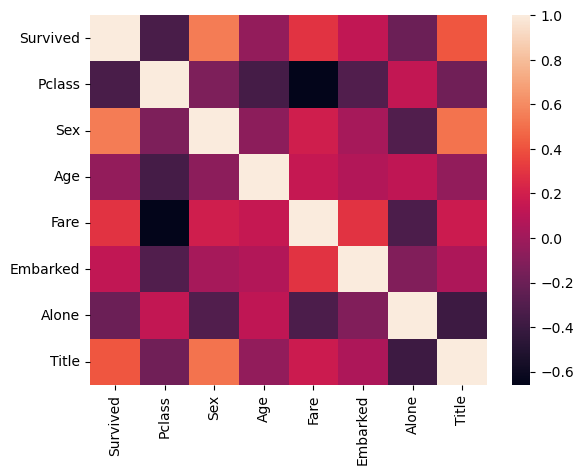

In [25]:
corr_train = train_data.corr()
sns.heatmap(corr_train)
plt.show()

# preparing training and testing data

In [26]:
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]
X_test = test_data.drop("PassengerId", axis=1)

# Neural Network
<img src = 'https://i.imgur.com/mIsGh53.jpg'>

## Import necessary libraries

In [27]:
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential

In [28]:
import tensorflow as tf

In [29]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

## Defining model
Here, I have used different number of neurons for each layer and different value for dropout. You can play with these hyperparameter for better outut.

In [30]:
def make_model():
    model = Sequential()
    model.add(Dense(units=32, input_shape=(7,), activation='relu'))
    model.add(Dense(units=64, activation='relu', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Dense(units=128, activation='relu', kernel_initializer='he_normal', use_bias=False))
    model.add(Dropout(0.1))
    model.add(Dense(units=64, activation='relu', kernel_initializer='he_normal', use_bias=False))
    model.add(Dropout(0.1))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=8, activation='relu', kernel_initializer='he_normal', use_bias=False))
    model.add(Dense(units=1, activation='sigmoid'))
    return model


model = make_model()

2023-02-22 16:46:52.756156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Model summary

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                256       
                                                                 
 dense_1 (Dense)             (None, 64)                2048      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 128)               8192      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8192      
                                                        

## Compiling and fitting model

In [43]:
X_train = X_train.values
Y_train = Y_train.values.astype(np.float32)

if MODE == Mode.TRAIN:
    print('hello')
    model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['acc'])
    model.fit(X_train, Y_train, batch_size=32, verbose=2, epochs=100)
    model.save('../../output/titanic/models/')
else:
    model.load_weights('../../output/titanic/models/')


hello
Epoch 1/100
28/28 - 1s - loss: 0.3319 - acc: 0.8530 - 901ms/epoch - 32ms/step
Epoch 2/100
28/28 - 0s - loss: 0.3223 - acc: 0.8519 - 49ms/epoch - 2ms/step
Epoch 3/100
28/28 - 0s - loss: 0.3250 - acc: 0.8586 - 49ms/epoch - 2ms/step
Epoch 4/100
28/28 - 0s - loss: 0.3256 - acc: 0.8597 - 47ms/epoch - 2ms/step
Epoch 5/100
28/28 - 0s - loss: 0.3235 - acc: 0.8597 - 51ms/epoch - 2ms/step
Epoch 6/100
28/28 - 0s - loss: 0.3259 - acc: 0.8575 - 48ms/epoch - 2ms/step
Epoch 7/100
28/28 - 0s - loss: 0.3231 - acc: 0.8563 - 48ms/epoch - 2ms/step
Epoch 8/100
28/28 - 0s - loss: 0.3294 - acc: 0.8507 - 48ms/epoch - 2ms/step
Epoch 9/100
28/28 - 0s - loss: 0.3237 - acc: 0.8418 - 48ms/epoch - 2ms/step
Epoch 10/100
28/28 - 0s - loss: 0.3262 - acc: 0.8552 - 46ms/epoch - 2ms/step
Epoch 11/100
28/28 - 0s - loss: 0.3221 - acc: 0.8575 - 48ms/epoch - 2ms/step
Epoch 12/100
28/28 - 0s - loss: 0.3286 - acc: 0.8563 - 178ms/epoch - 6ms/step
Epoch 13/100
28/28 - 0s - loss: 0.3157 - acc: 0.8597 - 50ms/epoch - 2ms/step

**Prediction for test data**

In [56]:
print(len(X_test))
X_test = X_test.values

predict = model.predict(X_test)
predict = (predict > 0.5).astype(int).ravel()

418
14/14 [==============================] - 0s 1000us/step


# For submission

In [57]:
submit = pd.DataFrame({"PassengerId": test_data.PassengerId, 'Survived': predict})
submit.to_csv("../../output/titanic/death_prediction_per_passenger.csv", index=False)

In [59]:
from sklearn import metrics

Y_pred_rand = (model.predict(X_train) > 0.5).astype(int)
print('Precision : ', np.round(metrics.precision_score(Y_train, Y_pred_rand) * 100, 2))
print('Accuracy : ', np.round(metrics.accuracy_score(Y_train, Y_pred_rand) * 100, 2))
print('Recall : ', np.round(metrics.recall_score(Y_train, Y_pred_rand) * 100, 2))
print('F1 score : ', np.round(metrics.f1_score(Y_train, Y_pred_rand) * 100, 2))
print('AUC : ', np.round(metrics.roc_auc_score(Y_train, Y_pred_rand) * 100, 2))

28/28 [==============================] - 0s 939us/step
Precision :  87.2
Accuracy :  85.75
Recall :  73.68
F1 score :  79.87
AUC :  83.47


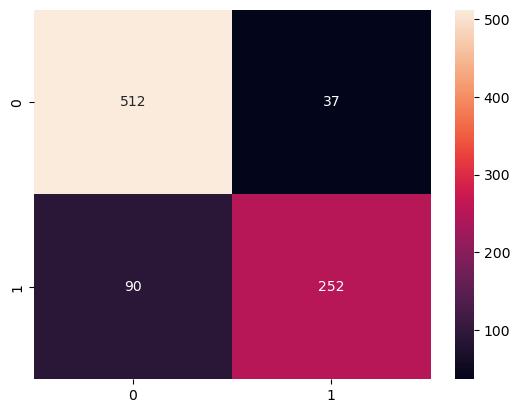

In [60]:
# plotting the confusion matrix in heatmap
matrix = metrics.confusion_matrix(Y_train, Y_pred_rand)
sns.heatmap(matrix, annot=True, fmt='g')
plt.show()